In [2]:
#Import all packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy 
import json

## Gather
1- The WeRateDogs Twitter archive. Download this file manually by clicking the following link: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv

In [3]:
twitter_archive_enhancediter = pd.read_csv('twitter-archive-enhanced.csv')

2- The tweet image predictions, should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [ ]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [4]:
#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

3- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [5]:

auth = tweepy.OAuthHandler('5Uur0mo4ol2kB8yhtZ1VxXS0u', 'h8E7fSpXWiMoBel7G1ZOAeu4Mgru0v0MtxH5ehYE1RKM89SiBH')
auth.set_access_token('303562412-ct9aNnU0FQR0UKJVn1i1W3Y8omqSewiQWUcRaygB', 'D3qslrbdOU5fqTOp951kOIuZbkeTPBodnjNYoEGFR63Ft')
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [ ]:

#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in twitter_archive_enhancediter['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

In [ ]:
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))

In [ ]:

my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)

In [ ]:

#we write this list into a txt file:

with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [6]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [ ]:
tweet_json.head()

In [ ]:
tweet_json.info()

## Assess

In [ ]:
twitter_archive_enhancediter

In [ ]:
image_prediction

In [ ]:
tweet_json

In [ ]:
twitter_archive_enhancediter.info()

In [ ]:
sum(twitter_archive_enhancediter.tweet_id.duplicated())

In [ ]:
twitter_archive_enhancediter.rating_denominator.value_counts()


In [ ]:
twitter_archive_enhancediter.rating_numerator.value_counts()

In [ ]:
image_prediction.info()

In [ ]:
sum(image_prediction.jpg_url.duplicated())

In [ ]:
tweet_json.info()

In [ ]:
tweet_json.retweeted_status.value_counts()

In [ ]:
tweet_json.source.value_counts()


### Quality
    Completeness, validity, accuracy, consistency (content issues)

    - twitter_archive
    1) Keep original ratings (no retweets) that have images
    2) Delete columns that won't be used for analysis
    3) Erroneous datatypes (doggo, floofer, pupper and puppo columns)
    4) Separate timestamp into day - month - year (3 columns)
    5) Correct numerators with decimals
    6) Correc denominators other than 10:

        a. Manually (few examples assessed by individual print text).

        b. Programatically (Tweets with denominator not equal to 10 are usually multiple dogs).

    - image_prediction
    1) Drop 66 jpg_url duplicated
    2) Create 1 column for image prediction and 1 column for confidence level
    3) Delete columns that won't be used for analysis
    
    - tweet_json
    1) Keep original tweets only

### Tidiness
    1) Change tweet_id to type int64 in order to merge with the other 2 tables
    2) All tables should be part of one dataset

## Cleaning

In [7]:
twitter_archive_clean = twitter_archive_enhancediter.copy()
image_prediction_clean = image_prediction.copy()
tweet_json_clean = tweet_json.copy()

1. Twitter archive - keep original ratings (no retweets) that have images.

In [8]:
#CODE: Delete retweets by filtering the NaN of retweeted_status_user_id
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]

#TEST
print(sum(twitter_archive_clean.retweeted_status_user_id.value_counts()))

0


2. Twitter archive - Delete columns that won't be used for analysis

In [9]:
#Code
twitter_archive_clean = twitter_archive_clean.drop(['source',
                                                    'in_reply_to_status_id',
                                                    'in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp', 
                                                    'expanded_urls'], 1)

In [10]:
#Test                                              
print(list(twitter_archive_clean))

['tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


3. Twitter_archive - Erroneous datatypes (doggo, floofer, pupper and puppo columns)
Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column. Then drop dogs. Sort by dogs_stage in order to then drop duplicated based on tweet_id except for the last occurrence.



In [10]:
#CODE: Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=['tweet_id',                                          
                                                                'timestamp',
                                                                'text',
                                                                'rating_numerator',
                                                                'rating_denominator',
                                                                'name'],
                               var_name='dogs', value_name='dogs_stage')

#CODE: drop dogs
twitter_archive_clean = twitter_archive_clean.drop('dogs', 1)

#CODE: Sort by dogs_stage then drop duplicated based on tweet_id except the last occurrence
twitter_archive_clean = twitter_archive_clean.sort_values('dogs_stage').drop_duplicates(subset='tweet_id', 
                                                                                        keep='last')

In [11]:
#Test
twitter_archive_clean['dogs_stage'].value_counts()

None       1831
pupper      234
doggo        75
puppo        25
floofer      10
Name: dogs_stage, dtype: int64

4. Twitter_archive - Separate timestamp into day - month - year (3 columns)

In [12]:
#CODE: convert timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#extract year, month and day to new columns
twitter_archive_clean['year'] = twitter_archive_clean['timestamp'].dt.year
twitter_archive_clean['month'] = twitter_archive_clean['timestamp'].dt.month
twitter_archive_clean['day'] = twitter_archive_clean['timestamp'].dt.day

#Finally drop timestamp column
twitter_archive_clean = twitter_archive_clean.drop('timestamp', 1)

In [14]:
#TEST
list(twitter_archive_clean)

['tweet_id',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dogs_stage',
 'year',
 'month',
 'day']

5. Twitter_archive - Correc numerators

In [13]:
#CODE: Create a new column with rating in float type to avoid converting all int column to float
twitter_archive_clean['rating'] = 10 * twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator'].astype(float)

#TEST
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating
2137,666454714377183233,I'll name the dogs from now on. This is Kreggo...,10,10,Kreggory,None,2015,11,17,10.0
3804,676897532954456065,Exotic handheld dog here. Appears unathletic. ...,5,10,None,None,2015,12,15,5.0
2156,666268910803644416,Very concerned about fellow dog trapped in com...,10,10,None,None,2015,11,16,10.0
2680,794926597468000259,This is Mack. He's rather h*ckin sleepy. Excep...,12,10,Mack,None,2016,11,5,12.0
4064,671138694582165504,Me running from commitment. 10/10 https://t.co...,10,10,None,None,2015,11,30,10.0


7. Image_prediction - Drop 66 jpg_url duplicated

In [14]:
#CODE: Delete duplicated jpg_url
image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last')

#TEST
sum(image_prediction_clean['jpg_url'].duplicated())

0

8. Image_prediction - Create 1 column for image prediction and 1 column for confidence level

In [15]:

#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
dog_type = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(image_prediction_clean):
    if image_prediction_clean['p1_dog'] == True:
        dog_type.append(image_prediction_clean['p1'])
        confidence_list.append(image_prediction_clean['p1_conf'])
    elif image_prediction_clean['p2_dog'] == True:
        dog_type.append(image_prediction_clean['p2'])
        confidence_list.append(image_prediction_clean['p2_conf'])
    elif image_prediction_clean['p3_dog'] == True:
        dog_type.append(image_prediction_clean['p3'])
        confidence_list.append(image_prediction_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

#series objects having index the image_prediction_clean column.        
image_prediction_clean.apply(image, axis=1)

#create new columns
image_prediction_clean['dog_type'] = dog_type
image_prediction_clean['confidence_list'] = confidence_list

In [22]:
#drop rows that has prediction_list 'error'
image_prediction_clean = image_prediction_clean[image_prediction_clean['dog_type'] != 'Error']

#TEST: 
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         1691 non-null   int64  
 1   jpg_url          1691 non-null   object 
 2   img_num          1691 non-null   int64  
 3   p1               1691 non-null   object 
 4   p1_conf          1691 non-null   float64
 5   p1_dog           1691 non-null   bool   
 6   p2               1691 non-null   object 
 7   p2_conf          1691 non-null   float64
 8   p2_dog           1691 non-null   bool   
 9   p3               1691 non-null   object 
 10  p3_conf          1691 non-null   float64
 11  p3_dog           1691 non-null   bool   
 12  dog_type         1691 non-null   object 
 13  confidence_list  1691 non-null   object 
dtypes: bool(3), float64(3), int64(2), object(6)
memory usage: 163.5+ KB


9. Image_prediction - Delete columns that won't be used for analysis



In [16]:
#CODE: print list of image_prediction columns
print(list(image_prediction_clean))

#Delete columns
image_prediction_clean = image_prediction_clean.drop(['img_num', 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#TEST
list(image_prediction_clean)

['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'dog_type', 'confidence_list']


['tweet_id', 'jpg_url', 'dog_type', 'confidence_list']

10. Tweet_json - keep 2174 original tweets



In [17]:

#CODE:
tweet_json_clean = tweet_json_clean[tweet_json_clean['retweeted_status'] == 'Original tweet']

#TEST
tweet_json_clean['retweeted_status'].value_counts()

Original tweet    2168
Name: retweeted_status, dtype: int64

11. Tidiness - Change tweet_id to type int64 in order to merge with the other 2 tables

In [18]:

#CODE: change tweet_id from str to int
tweet_json_clean['tweet_id'] = tweet_json_clean['tweet_id'].astype(int)

#TEST
tweet_json_clean['tweet_id'].dtypes

dtype('int64')

12. Tidiness - All tables should be part of one dataset



In [19]:
#CODE: create a new dataframe that merge twitter_archive_clean and 
#image_prediction_clean
df_twitter1 = pd.merge(twitter_archive_clean, 
                      image_prediction_clean, 
                      how = 'left', on = ['tweet_id'])

#keep rows that have picture (jpg_url)
df_twitter1 = df_twitter1[df_twitter1['jpg_url'].notnull()]

#TEST
df_twitter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 2174
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1928 non-null   int64  
 1   text                1928 non-null   object 
 2   rating_numerator    1928 non-null   int64  
 3   rating_denominator  1928 non-null   int64  
 4   name                1928 non-null   object 
 5   dogs_stage          1928 non-null   object 
 6   year                1928 non-null   int64  
 7   month               1928 non-null   int64  
 8   day                 1928 non-null   int64  
 9   rating              1928 non-null   float64
 10  jpg_url             1928 non-null   object 
 11  dog_type            1928 non-null   object 
 12  confidence_list     1928 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 210.9+ KB


In [20]:
df_twitter1.sample(2)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list
1961,727524757080539137,This pupper had to undergo emergency haircut s...,10,10,None,pupper,2016,5,3,10.0,https://pbs.twimg.com/media/Chiv6BAW4AAiQvH.jpg,Pomeranian,0.958834
1481,822975315408461824,This is Albus. He's soaked as h*ck. Seems to h...,12,10,Albus,None,2017,1,22,12.0,https://pbs.twimg.com/media/C2vLrpvWIAA3LM3.jpg,Pembroke,0.233162


In [21]:

#CODE: create a new dataframe that merge df_twitter and tweet_json_clean
df_twitter = pd.merge(df_twitter1, tweet_json_clean, 
                      how = 'left', on = ['tweet_id'])

#TEST
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1928 non-null   int64  
 1   text                1928 non-null   object 
 2   rating_numerator    1928 non-null   int64  
 3   rating_denominator  1928 non-null   int64  
 4   name                1928 non-null   object 
 5   dogs_stage          1928 non-null   object 
 6   year                1928 non-null   int64  
 7   month               1928 non-null   int64  
 8   day                 1928 non-null   int64  
 9   rating              1928 non-null   float64
 10  jpg_url             1928 non-null   object 
 11  dog_type            1928 non-null   object 
 12  confidence_list     1928 non-null   object 
 13  favorite_count      1922 non-null   float64
 14  retweet_count       1922 non-null   float64
 15  followers_count     1922 non-null   float64
 16  friend

In [22]:
df_twitter.sample(2)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
970,675706639471788032,This is a Sizzlin Menorah spaniel from Brookly...,10,10,a,None,2015,12,12,10.0,https://pbs.twimg.com/media/CWCXj35VEAIFvtk.jpg,English_springer,0.9903,614.0,87.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/7E0AiJXPmI
1022,805932879469572096,This is Major. He put on a tie for his first r...,12,10,Major,None,2016,12,6,12.0,https://pbs.twimg.com/media/Cy8_qt0UUAAHuuN.jpg,Norwegian_elkhound,0.657967,8195.0,1893.0,8959823.0,17.0,Twitter for iPhone,Original tweet,https://t.co/3P9dKV5Me1


## Storing, Analyzing, and Visualizing Data¶


In [23]:

#Store the clean DataFrame in a CSV file
df_twitter.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

### Insight one & visualization¶
Golden retriever is the most common dog in this dataset.

In [30]:
df_twitter['dog_type'].value_counts()


golden_retriever      143
Labrador_retriever    103
Pembroke               94
Chihuahua              87
pug                    60
                     ... 
silky_terrier           1
standard_schnauzer      1
Japanese_spaniel        1
Scotch_terrier          1
EntleBucher             1
Name: dog_type, Length: 113, dtype: int64

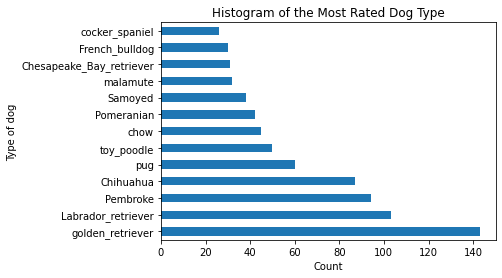

In [32]:
df_dog_type = df_twitter.groupby('dog_type').filter(lambda x: len(x) >= 25)

df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

### Insight two
Japanese_spaniel has the lowest average rating Clumber has the highest average rating

In [34]:
df_dog_type_mean = df_twitter.groupby('dog_type').mean()

In [35]:
df_dog_type_mean.head()

,tweet_id,rating_numerator,rating_denominator,year,month,day,rating,favorite_count,retweet_count,followers_count,friends_count
dog_type,,,,,,,,,,,
Afghan_hound,8.095999e+17,8.000000,10.0,2016.500000,6.00,16.000000,8.000000,10775.500000,3011.500000,8.959824e+06,17.0
Airedale,7.184489e+17,9.833333,10.0,2015.583333,8.75,15.916667,9.833333,4671.750000,1177.250000,8.959850e+06,17.0
American_Staffordshire_terrier,7.597284e+17,10.312500,10.0,2016.187500,5.25,15.000000,10.312500,7480.533333,1738.333333,8.959839e+06,17.0
Appenzeller,7.939334e+17,11.000000,10.0,2016.500000,4.50,18.500000,11.000000,6502.000000,1211.000000,8.959833e+06,17.0
Australian_terrier,7.785921e+17,11.500000,10.0,2016.500000,3.50,7.000000,11.500000,9897.500000,2623.500000,8.959834e+06,17.0


In [36]:
df_dog_type_sorted = df_dog_type_mean['rating'].sort_values()

df_dog_type_sorted

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
soft-coated_wheaten_terrier     8.800000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
                                 ...    
Irish_setter                   12.333333
Pomeranian                     12.476190
Saluki                         12.500000
Bouvier_des_Flandres           13.000000
clumber                        27.000000
Name: rating, Length: 113, dtype: float64

In [37]:
df_twitter[df_twitter['dog_type'] == 'golden_retriever']


,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
8,667530908589760512,Meet Naphaniel. He doesn't necessarily enjoy h...,10.0,10.0,Naphaniel,None,2015,11,20,10.0,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,golden_retriever,0.633037,433.0,219.0,8959867.0,17.0,Twitter Web Client,Original tweet,https://t.co/xoRWyQTcmy
30,667044094246576128,12/10 gimme now https://t.co/QZAnwgnOMB,12.0,10.0,None,None,2015,11,18,12.0,https://pbs.twimg.com/media/CUHREBXXAAE6A9b.jpg,golden_retriever,0.765266,174.0,44.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/QZAnwgnOMB
37,667160273090932737,This is Bradlay. He is a Ronaldinho Matsuyama ...,11.0,10.0,Bradlay,None,2015,11,19,11.0,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,golden_retriever,0.471351,234.0,55.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/DKhgkMx4N1
43,667182792070062081,This is Timison. He just told an awful joke bu...,10.0,10.0,Timison,None,2015,11,19,10.0,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,golden_retriever,0.949892,13176.0,5591.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/s2yYuHabWl
46,667211855547486208,This is Genevieve. She is a golden retriever c...,9.0,10.0,Genevieve,None,2015,11,19,9.0,https://pbs.twimg.com/media/CUJppKJWoAA75NP.jpg,golden_retriever,0.462556,448.0,220.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/azEoGqVonH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,693262851218264065,I hope you guys enjoy this beautiful snowy pup...,11.0,10.0,None,pupper,2016,1,30,11.0,https://pbs.twimg.com/media/CZ724fDUYAAytS-.jpg,golden_retriever,0.989333,2134.0,477.0,8959849.0,17.0,Twitter for iPhone,Original tweet,https://t.co/DYUsHtL2aR
1589,675740360753160193,Here's a pupper licking in slow motion. 12/10 ...,12.0,10.0,None,pupper,2015,12,12,12.0,https://pbs.twimg.com/ext_tw_video_thumb/67574...,golden_retriever,0.800495,1109.0,318.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/AUJi8ujxw9
1599,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",12.0,10.0,Maggie,pupper,2016,7,31,12.0,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,golden_retriever,0.985876,5803.0,1848.0,8959831.0,17.0,Twitter for iPhone,Original tweet,https://t.co/MYwR4DQKll
1616,859607811541651456,Sorry for the lack of posts today. I came home...,13.0,10.0,None,puppo,2017,5,3,13.0,https://pbs.twimg.com/media/C-3wvtxXcAUTuBE.jpg,golden_retriever,0.895529,17441.0,1418.0,8959820.0,17.0,Twitter for iPhone,Original tweet,https://t.co/GL6vzAbHrv


### Insight three & visualization

Dog_types with low number of ratings show a high variaty of mean ratings.

In [39]:
df_dog_type_count = df_twitter.groupby('dog_type').count()
df_dog_type_count

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
dog_type,,,,,,,,,,,,,,,,,,,
Afghan_hound,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Airedale,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
American_Staffordshire_terrier,16,16,16,16,16,16,16,16,16,16,16,16,15,15,15,15,15,15,15
Appenzeller,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Australian_terrier,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toy_poodle,50,50,50,50,50,50,50,50,50,50,50,50,49,49,49,49,49,49,49
toy_terrier,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
vizsla,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [40]:
dog_type_count = df_dog_type_count['rating']
dog_type_mean = df_dog_type_mean['rating']
dog_type_mean

dog_type
Afghan_hound                       8.000000
Airedale                           9.833333
American_Staffordshire_terrier    10.312500
Appenzeller                       11.000000
Australian_terrier                11.500000
                                    ...    
toy_poodle                        11.020000
toy_terrier                       10.333333
vizsla                            10.846154
whippet                           10.181818
wire-haired_fox_terrier           11.500000
Name: rating, Length: 113, dtype: float64

In [41]:
df = pd.DataFrame()
df['dog_type_count'] = dog_type_count
df['dog_type_mean'] = dog_type_mean
df

,dog_type_count,dog_type_mean
dog_type,,
Afghan_hound,2,8.000000
Airedale,12,9.833333
American_Staffordshire_terrier,16,10.312500
Appenzeller,2,11.000000
Australian_terrier,2,11.500000
...,...,...
toy_poodle,50,11.020000
toy_terrier,3,10.333333
vizsla,13,10.846154


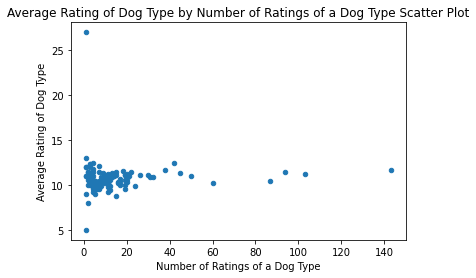

In [42]:
df.plot(x='dog_type_count', y='dog_type_mean', kind='scatter')
plt.xlabel('Number of Ratings of a Dog Type')
plt.ylabel('Average Rating of Dog Type')
plt.title('Average Rating of Dog Type by Number of Ratings of a Dog Type Scatter Plot')

fig = plt.gcf()
#plt.savefig('X:/' + newName + '.png', 
fig.savefig('output2.png',bbox_inches='tight');

### Insight four & visualization

The highest ratings do not receive the most retweets.


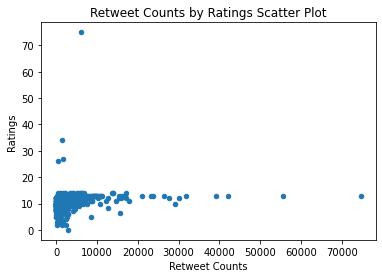

In [43]:
df_twitter.plot(x='retweet_count', y='rating', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');